In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
training_set = pd.read_csv("training_indicators5_log.csv")
testing_set = pd.read_csv("testing_indicators5_log.csv")
train_df = pd.read_csv("training_indicators5_log.csv")
test_df = pd.read_csv("testing_indicators5_log.csv")

In [3]:
features = [
    "delta price_t", "delta price_t-1", "delta price_t-2",
    "delta price_t-3", "delta price_t-4",
    "delta price_t-5", "delta price_t-6",
    "delta price_t-7", "order imbalance",
    "macd signal", "log spread", "mid price",
    "log ADX", "RSI", "open interest", "vol"
]
target = "future 10t return"

X_train = train_df[features].values
X_test = test_df[features].values
y_train = train_df[[target]].values
y_test = test_df[[target]].values

y_train_1d = y_train.ravel()

In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled  = sc.transform(X_test)

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

models = {
    "LR": LinearRegression(),
    # 這兩個建議用標準化後的 X
    "SVR": SVR(
        kernel='rbf',
        C=1.0,
        epsilon=0.01
    ),
    "XGB": XGBRegressor(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=0
    ),
    # 樹模型：用原始 X 即可
    "DT": DecisionTreeRegressor(
        max_depth=5,
        random_state=0
    ),
    "RF": RandomForestRegressor(
        n_estimators=1200,
        max_depth=6,
        random_state=0
    )
}


In [6]:
preds = {}

for name, model in models.items():
    if name in ["LR", "RF", "DT"]:
        Xtr, Xte = X_train, X_test
    else:
        Xtr, Xte = X_train_scaled, X_test_scaled

    model.fit(Xtr, y_train_1d)
    preds[name] = model.predict(Xte)

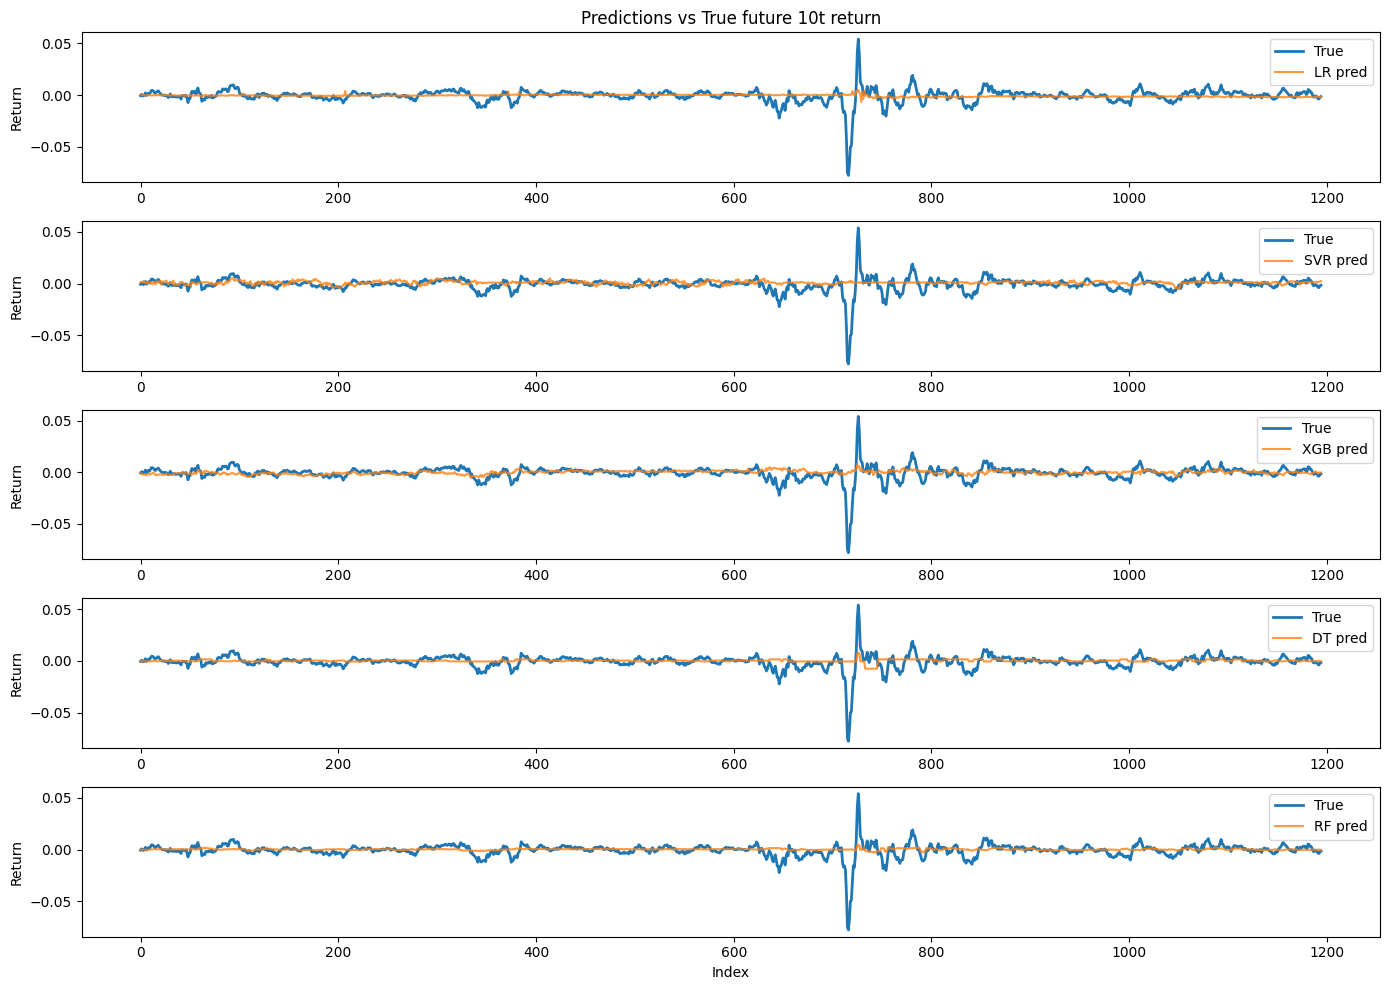

In [7]:
y_test_1d = y_test.ravel()
model_list = ["LR", "SVR", "XGB", "DT", "RF"]

plt.figure(figsize=(14,10))

for i, name in enumerate(model_list, 1):
    plt.subplot(len(model_list), 1, i)
    plt.plot(y_test_1d, label="True", linewidth=2)
    plt.plot(preds[name], label=f"{name} pred", alpha=0.8)
    plt.ylabel("Return")
    plt.legend(loc="upper right")
    if i == 1:
        plt.title(f"Predictions vs True future 10t return")
    if i == len(model_list):
        plt.xlabel("Index")

plt.tight_layout()
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error

y_test_1d = y_test.ravel()

mse_results = {}

for name in preds.keys():
    mse_results[name] = mean_squared_error(y_test_1d, preds[name])

mse_results

{'LR': 4.631621448386846e-05,
 'SVR': 5.015644777407465e-05,
 'XGB': 4.6047363656421675e-05,
 'DT': 4.6623459533585484e-05,
 'RF': 4.5016295760082716e-05}

In [9]:
rmse_results = {name: np.sqrt(mse) for name, mse in mse_results.items()}
rmse_results

{'LR': np.float64(0.006805601698885152),
 'SVR': np.float64(0.007082121700032741),
 'XGB': np.float64(0.006785820779863087),
 'DT': np.float64(0.0068281373399768025),
 'RF': np.float64(0.006709418436800817)}

In [10]:
import yfinance as yf

ticker = "^TNX"
data = yf.download(ticker, period="1y")

risk_free_rate = data['Close'].iloc[-1] / 100
risk_free_rate = risk_free_rate["^TNX"]/121

/tmp/ipython-input-3789647642.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period="1y")
[*********************100%***********************]  1 of 1 completed


In [11]:
def Sharp(total_ret):
    ret = np.mean(total_ret)
    vol = np.std(total_ret)

    N = len(total_ret)
    if N == 0 or vol == 0:
        return np.nan

    T_years = (len(data) * 5) / (60 * 24 * 365)

    # 年化
    ret_annual = (1 + ret)**(1/T_years) - 1
    vol_annual = vol * (1 / np.sqrt(T_years))

    return float((ret_annual - risk_free_rate) / vol_annual)

In [12]:
fee = 0.0005
ATR = testing_set["ATR%"]
data = pd.read_csv("testing_data.csv")
df = data.copy()
price_plt = df.iloc[::5, :].reset_index(drop=True)

def backtest(y_pred, TP, SL):
  result = {"total_ret": [],
        "long_entries": [],
        "short_entries": [],
        "exits": []
        }
  position = ""
  initial_price = 0
  end_price = 0
  pos_return = 0
  total_ret = []

  long_entries = []
  short_entries = []
  exits = []


  for i in range(len(y_pred)):
      if position == "":
          if (y_pred[i] > 1*fee):
              position = "long"
              initial_price = price_plt["close"][i]
              long_entries.append((i, initial_price))

          elif (y_pred[i] < -1*fee):
              position = "short"
              initial_price = price_plt["close"][i]
              short_entries.append((i, initial_price))

      elif position == "long":
          end_price = price_plt["close"][i]
          pos_return = (end_price * (1-fee) / initial_price * (1+fee)) - 1
          if (pos_return >= TP*ATR[i]) or (pos_return <= -SL*ATR[i]):
              position = ""
              initial_price = 0
              total_ret.append(pos_return)
              exits.append((i, end_price))

      elif position == "short":
          end_price = price_plt["close"][i]
          pos_return = 1 - (end_price  * (1+fee)/ initial_price * (1-fee))
          if (pos_return >= TP*ATR[i]) or (pos_return <= -SL*ATR[i]):
              position = ""
              initial_price = 0
              total_ret.append(pos_return)
              exits.append((i, end_price))
  result["total_ret"] = total_ret
  result["long_entries"] = long_entries
  result["short_entries"] = short_entries
  result["exits"] = exits
  return result

In [13]:
from tqdm import tqdm  # 顯示進度條

def TPSL_optimizer(y_pred):
  best_SR = -np.inf
  best_TP, best_SL = 0, 0

  TP_range = np.arange(0.5, 3.1, 0.1)
  SL_range = np.arange(0.5, 3.1, 0.1)

  for TP in tqdm(TP_range, desc="Searching TP"):
      for SL in SL_range:
          SR = Sharp(backtest(y_pred, TP, SL)["total_ret"])
          if SR > best_SR:
              best_SR = SR
              best_TP, best_SL = TP, SL
  return TP, SL

In [14]:
LR_TP_SL = TPSL_optimizer(preds["LR"])
SVR_TP_SL = TPSL_optimizer(preds["SVR"])
XGB_TP_SL = TPSL_optimizer(preds["XGB"])
DT_TP_SL = TPSL_optimizer(preds["DT"])
RF_TP_SL = TPSL_optimizer(preds["RF"])

Searching TP: 100%|██████████| 26/26 [00:02<00:00,  9.49it/s]


In [17]:
LR_backtest = backtest(preds["LR"], LR_TP_SL[0], LR_TP_SL[1])
SVR_backtest = backtest(preds["SVR"], SVR_TP_SL[0], SVR_TP_SL[1])
XGB_backtest = backtest(preds["XGB"], XGB_TP_SL[0], XGB_TP_SL[1])
DT_backtest = backtest(preds["DT"], DT_TP_SL[0], DT_TP_SL[1])
RF_backtest = backtest(preds["RF"], RF_TP_SL[0], RF_TP_SL[1])

In [18]:
import json

def save(backtest_result, filename_prefix):
    # 統一為 dict 結構
    if isinstance(backtest_result, dict):
        result_dict = backtest_result
    else:
        # tuple: (total_ret, long_entries, short_entries, exits)
        result_dict = {
            "total_ret":     backtest_result[0],
            "long_entries":  backtest_result[1],
            "short_entries": backtest_result[2],
            "exits":         backtest_result[3]
        }

    # JSON 不支援 tuple，要全部轉 list
    for key in result_dict:
        result_dict[key] = [list(x) if isinstance(x, tuple) else x
                            for x in result_dict[key]]

    # 存檔
    filename = f"{filename_prefix}.json"
    with open(filename, "w") as f:
        json.dump(result_dict, f, indent=4)

    print(f"Saved: {filename}")

# -------------------------
# 分別存 5 個模型
# -------------------------
save(LR_backtest,  "LR_backtest")
save(SVR_backtest, "SVR_backtest")
save(XGB_backtest, "XGB_backtest")
save(DT_backtest,  "DT_backtest")
save(RF_backtest,  "RF_backtest")

Saved: LR_backtest.json
Saved: SVR_backtest.json
Saved: XGB_backtest.json
Saved: DT_backtest.json
Saved: RF_backtest.json
